In [1]:
# Code derived from class notebooks for MACSS 60000, Computational Content Analysis,
# written by Bhargav Desikan, University of Chicago

#cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim #For topic modeling
import requests #For downloading our datasets
import os #To get files
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nice
import spacy # comp-linguistics

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
%matplotlib inline

import itertools
import json

In [2]:
# to get the data
!git clone git@github.com:Inusette/Identifying-depression.git 

In [3]:
def getPosts(dir):
    dict = {
        'filename': [],
        'text': []
    }
    files = os.listdir(dir)
    for file in files:
        with open(dir + file) as f:
            dict['filename'].append(file)
            dict['text'].append(f.read())

    return pd.DataFrame(dict)

Get the posts. Since there are more depressed posts in the dataset, take only a number equal to the number of non-depressed posts. Tag each post with whether it comes from a depression forum:

In [4]:
nondepDir = "../data/Identifying-depression/Data_Collector/reddit_non_depression/"
nondepPosts = getPosts(nondepDir)
nondepPosts['depression'] = 0
depDir = "../data/Identifying-depression/Data_Collector/reddit_depression/"
depPosts = getPosts(depDir)
depPosts = depPosts[:len(nondepPosts)]
depPosts['depression'] = 1
allPosts = pd.concat([nondepPosts, depPosts], ignore_index=True)
allPosts

,filename,text,depression
0,Breesasha.txt,Ending a 6 year friendship over her husband\n\...,0
1,jasmarie98.txt,"Went through tough times, friends weren't ther...",0
2,UnknownDude007.txt,Is there any chance of me being able to fix th...,0
3,Trumpeachment.txt,My dad is about to be 65. I'm scared suddenly ...,0
4,smoofsmooff.txt,I want to fix my best friend and I's friendshi...,0
...,...,...,...
1091,fufukuschlipups.txt,Even in objectively good circumstances I feel ...,1
1092,StrangeStep.txt,"Does anyone else ""live inside their head""?\nHi...",1
1093,MisterGiraffaxx.txt,My birthday is in 15 days.\nI have never felt ...,1
1094,Marleaubugatti.txt,Antidepressants for GAD\nAre any of you taking...,1


Load the *spacy* library and use it tokenize the posts:

In [6]:
nlp = spacy.load("en_core_web_sm")

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [7]:
allPosts['tokenized'] = allPosts['text'].apply(word_tokenize)
allPosts.head()

,filename,text,depression,tokenized
0,Breesasha.txt,Ending a 6 year friendship over her husband\n\...,0,"[Ending, a, 6, year, friendship, over, her, hu..."
1,jasmarie98.txt,"Went through tough times, friends weren't ther...",0,"[Went, through, tough, times, friends, were, n..."
2,UnknownDude007.txt,Is there any chance of me being able to fix th...,0,"[Is, there, any, chance, of, me, being, able, ..."
3,Trumpeachment.txt,My dad is about to be 65. I'm scared suddenly ...,0,"[My, dad, is, about, to, be, 65, I, 'm, scared..."
4,smoofsmooff.txt,I want to fix my best friend and I's friendshi...,0,"[I, want, to, fix, my, best, friend, and, I, '..."


Normalize the posts with Bhargav's function:

In [8]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [9]:
allPosts['normalized'] = allPosts['tokenized'].apply(normalizeTokens)
allPosts.head()

,filename,text,depression,tokenized,normalized
0,Breesasha.txt,Ending a 6 year friendship over her husband\n\...,0,"[Ending, a, 6, year, friendship, over, her, hu...","[end, year, friendship, husband, 24f, sure, fe..."
1,jasmarie98.txt,"Went through tough times, friends weren't ther...",0,"[Went, through, tough, times, friends, were, n...","[go, tough, time, friend, want, life, good, fr..."
2,UnknownDude007.txt,Is there any chance of me being able to fix th...,0,"[Is, there, any, chance, of, me, being, able, ...","[chance, able, fix, friendship, hello, need, a..."
3,Trumpeachment.txt,My dad is about to be 65. I'm scared suddenly ...,0,"[My, dad, is, about, to, be, 65, I, 'm, scared...","[dad, m, scared, suddenly, age, m, sad, year, ..."
4,smoofsmooff.txt,I want to fix my best friend and I's friendshi...,0,"[I, want, to, fix, my, best, friend, and, I, '...","[want, fix, good, friend, friendship, m, sure,..."


In [11]:
allPosts[['normalized']]

,normalized
0,"[end, year, friendship, husband, 24f, sure, fe..."
1,"[go, tough, time, friend, want, life, good, fr..."
2,"[chance, able, fix, friendship, hello, need, a..."
3,"[dad, m, scared, suddenly, age, m, sad, year, ..."
4,"[want, fix, good, friend, friendship, m, sure,..."
...,...
1091,"[objectively, good, circumstance, feel, emptin..."
1092,"[live, inside, head, hi, post, feel, like, m, ..."
1093,"[birthday, day, feel, unexcited, amp, apatheti..."
1094,"[antidepressant, gad, take, antidepressant, ga..."


Use *sklearn*'s tf-idf vectorizer to convert the posts to vectors, creating a document-term matrix:

In [12]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(allPosts['text'])
TFVects

<1096x3699 sparse matrix of type '<class 'numpy.float64'>'
	with 67907 stored elements in Compressed Sparse Row format>

In [17]:
TFVects[:10,:20].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.14247497,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.07414515, 0.        , 0.        , 0.        ,
         0.        , 0.08131387, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.01707346,
         0.        , 0.        , 0.        , 0.00829254, 0.15262178,
         0.00853673, 0.00766908, 0.06545339, 0.18362357, 0.        ,
         0.        , 0.00841056, 0.        , 0.        , 0.01517911],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        

In [13]:
TFVectorizer.vocabulary_

{'ending': 1115,
 'year': 3678,
 'friendship': 1370,
 'husband': 1656,
 'sure': 3223,
 'feel': 1264,
 'friend': 1367,
 'behavior': 360,
 'considering': 732,
 'little': 1967,
 'backstory': 317,
 've': 3519,
 'known': 1872,
 'years': 3680,
 'met': 2113,
 'boyfriends': 453,
 'used': 3497,
 'double': 1020,
 'dates': 854,
 'lot': 2001,
 'couple': 782,
 'activities': 109,
 'sleepovers': 2993,
 'things': 3318,
 'stayed': 3122,
 'friends': 1369,
 'despite': 923,
 'break': 462,
 'ups': 3488,
 'time': 3345,
 'rocky': 2778,
 'busy': 513,
 'schedule': 2836,
 'usually': 3505,
 'works': 3648,
 '40': 49,
 '60': 56,
 'hours': 1634,
 'given': 1429,
 'week': 3589,
 'lived': 1969,
 'city': 618,
 '18': 14,
 'months': 2156,
 'didn': 940,
 'hang': 1523,
 'liked': 1950,
 'kept': 1842,
 'touch': 3372,
 'social': 3026,
 'media': 2078,
 'expressed': 1202,
 'desire': 915,
 'doing': 1010,
 'road': 2776,
 'trips': 3406,
 'local': 1978,
 'financially': 1289,
 'typically': 3436,
 'birthdays': 393,
 'problem': 2522,


Try k-means analysis with k=2 and k=3 (you can also try k=4 but it is worse than 3):

In [18]:
numClusters = 2
KM2 = sklearn.cluster.KMeans(n_clusters = numClusters, init='k-means++')
KM2.fit(TFVects)
print("For {} clusters:".format(numClusters))
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(allPosts['depression'], KM2.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(allPosts['depression'], KM2.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(allPosts['depression'], KM2.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(allPosts['depression'], KM2.labels_)))

/Users/dan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For 2 clusters:
Homogeneity: 0.122
Completeness: 0.149
V-measure: 0.134
Adjusted Rand Score: 0.120


In [20]:
numClusters = 3
KM3 = sklearn.cluster.KMeans(n_clusters = numClusters, init='k-means++')
KM3.fit(TFVects)
print("For {} clusters:".format(numClusters))
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(allPosts['depression'], KM3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(allPosts['depression'], KM3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(allPosts['depression'], KM3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(allPosts['depression'], KM3.labels_)))

/Users/dan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For 3 clusters:
Homogeneity: 0.297
Completeness: 0.206
V-measure: 0.244
Adjusted Rand Score: 0.280


Add the KM2 and KM3 predictions to the dataframe:

In [28]:
allPosts['kmeans_2_predictions'] = KM2.labels_
allPosts['kmeans_3_predictions'] = KM3.labels_
# since both take 0 as the depression cluster (see below), we need to adjust the labels to match the actual labels
allPosts['kmeans_2_predictions_adjusted'] = [1 if x == 0 else 0 for x in KM2.labels_]
allPosts['kmeans_3_predictions_adjusted'] = [1 if x == 0 else 0 for x in KM3.labels_]
allPosts[::100]

,filename,text,depression,tokenized,normalized,kmeans_2_predictions,kmeans_3_predictions,kmeans_3_predictions_adjusted,kmeans_2_predictions_adjusted
0,Breesasha.txt,Ending a 6 year friendship over her husband\n\...,0,"[Ending, a, 6, year, friendship, over, her, hu...","[end, year, friendship, husband, 24f, sure, fe...",0,1,0,1
100,jendiaz9732.txt,Should I cut her off finally?\nBeen knowing be...,0,"[Should, I, cut, her, off, finally, Been, know...","[cut, finally, know, bestie, ve, lot, blah, bl...",1,0,1,0
200,mariadelmar_00.txt,"I News Your advice\nHi, I’m 18. \n\nmy mom pas...",0,"[I, News, Your, advice, Hi, I, ’m, 18, my, mom...","[news, advice, hi, m, mom, pass, away, year, a...",1,2,0,0
300,Seligordjvison.txt,Special friendship\n,0,"[Special, friendship]","[special, friendship]",1,0,1,0
400,friendshipbootcamp.txt,Are friendship ultimatums a good or bad thing?...,0,"[Are, friendship, ultimatums, a, good, or, bad...","[friendship, ultimatum, good, bad, thing, frie...",1,1,0,0
500,AletaXYZ.txt,Should family be more than this?\nI’m 24 and n...,0,"[Should, family, be, more, than, this, I, ’m, ...","[family, m, kid, family, like, break, dad, som...",1,2,0,0
600,Quarter_Pounders.txt,My latest addiction for pain relief\nCannabis ...,1,"[My, latest, addiction, for, pain, relief, Can...","[late, addiction, pain, relief, cannabis, pres...",1,0,1,0
700,dredscottsdreadlocks.txt,"Well, it's been a year now since I tried killi...",1,"[Well, it, 's, been, a, year, now, since, I, t...","[year, try, kill, year, ago, december, try, ki...",1,0,1,0
800,AnonyRedditor2301.txt,How are y’all doing?\nJust honestly asking.\n\...,1,"[How, are, y’, all, doing, Just, honestly, ask...","[y, honestly, ask, m, take, thing, day, day, f...",1,0,1,0
900,most_unoriginal_ign.txt,Anyone else get more depressed than usual on y...,1,"[Anyone, else, get, more, depressed, than, usu...","[depressed, usual, birthday, today, birthday, ...",1,0,1,0


See how KM2 did:

In [29]:
allPosts[allPosts['kmeans_2_predictions_adjusted'] == allPosts['depression']].shape

(492, 9)

In [30]:
allPosts[allPosts['kmeans_2_predictions_adjusted'] != allPosts['depression']].shape

(604, 9)

It actually does worse than chance -- not a very good classifier! Yet it was still able to pick up on depressiveness, presumably from the more extreme depressed posts.

In [32]:
allPosts[allPosts['kmeans_3_predictions_adjusted'] == allPosts['depression']].shape

(883, 9)

In [34]:
allPosts[allPosts['kmeans_3_predictions_adjusted'] != allPosts['depression']].shape

(213, 9)

KM3 does way better. Let's examine the top terms for each cluster in both models:

In [36]:
terms = TFVectorizer.get_feature_names_out()
terms

array(['00', '000', '01', ..., 'zoloft', 'zombie', 'zone'], dtype=object)

In [37]:
numClusters = 2
print("Top terms per cluster: ({} clusters)".format(numClusters))
centroids2 = KM2.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in centroids2[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster: (2 clusters)
Cluster 0:
 time
 feel
 know
 friends
 friend
 ve
 really
 want
 didn
 life


Cluster 1:
 feel
 know
 want
 friends
 ve
 time
 friend
 really
 life
 people




In [39]:
numClusters = 3
print("Top terms per cluster: ({} clusters)".format(numClusters))
centroids3 = KM3.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in centroids3[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster: (3 clusters)
Cluster 0:
 feel
 life
 want
 people
 depression
 ve
 know
 think
 really
 time


Cluster 1:
 friend
 friends
 know
 best
 feel
 ve
 time
 really
 want
 people


Cluster 2:
 family
 mom
 dad
 sister
 parents
 mother
 brother
 father
 house
 time




We can see that for km3, cluster 0 is depressed people, cluster 1 is young people, and cluster 2 is old people. Let's visualize the clusters: 

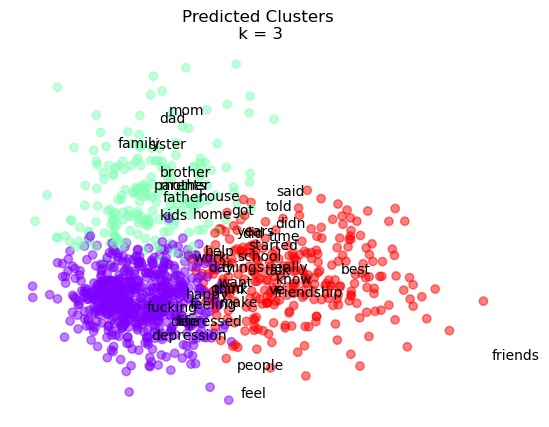

In [40]:
PCA = sklearn.decomposition.PCA(n_components = 2).fit(TFVects.toarray())
reducedPCA_data = PCA.transform(TFVects.toarray())

colors = list(plt.cm.rainbow((0, 1, 0.5)))
colors_p = [colors[l] for l in KM3.labels_]

components = PCA.components_
keyword_ids = list(set(centroids3[:,:20].flatten()))
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:] 
y = components[:,keyword_ids][1,:]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numClusters))
plt.show()

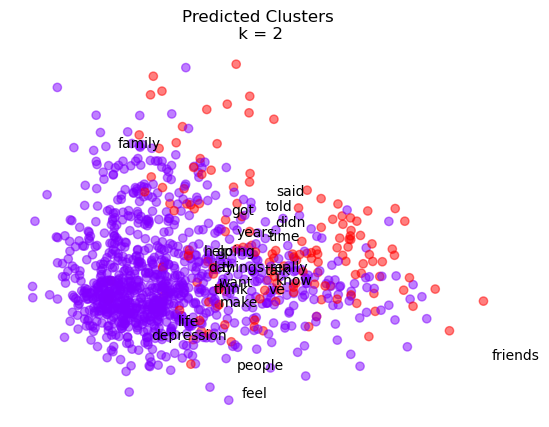

In [43]:
PCA = sklearn.decomposition.PCA(n_components = 2).fit(TFVects.toarray())
reducedPCA_data = PCA.transform(TFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(1,0,numClusters)))
colors_p = [colors[l] for l in KM2.labels_]

components = PCA.components_
keyword_ids = list(set(centroids2[:,:20].flatten()))
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:] 
y = components[:,keyword_ids][1,:]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numClusters))
plt.show()

Done!